# Imports

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [14]:
houses = pd.read_csv('https://raw.githubusercontent.com/MerleSt/HousingPricePrediction/main/Data/housing_prices.csv')

In [15]:
houses.drop(columns='Id', inplace=True)

# Split Data

In [16]:
X = houses.copy()
y = X.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess Data

In [31]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

## Encoding

In [32]:
# Define orders
order_LandSlope = ['Sev', 'Mod', 'Gtl']
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageFinish = ['NA', 'Unf', 'RFn', 'Fin']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_LandSlope, order_ExterQual, order_ExterCond, order_BsmtQual, order_BsmtCond, 
        order_BsmtExposure, order_BsmtFinType1, order_BsmtFinType2, order_HeatingQC, 
        order_KitchenQual, order_FireplaceQu, order_GarageFinish, order_GarageQual, 
        order_GarageCond, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


In [43]:
cat_ordinal = [
    'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence'
]
cat_onehot = [col for col in cat_features if col not in cat_ordinal]

## Pipelines

In [44]:
num_pipeline = make_pipeline(
    SimpleImputer()
)

cat_ordinal_pipe = make_pipeline(
    SimpleImputer(strategy='constant'),
    ordinal_enc
)

cat_onehot_pipe = make_pipeline(
    SimpleImputer(strategy='constant'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

In [45]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_features),
    ('onehot', cat_onehot_pipe, cat_onehot),
    ('ordinal', cat_ordinal_pipe, cat_ordinal)
])

# __Model 1__ Decision Tree Regressor

In [115]:
pipeline = make_pipeline(preprocessor, StandardScaler(), DecisionTreeRegressor())

In [116]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullB...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['LandSlope', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [117]:
model_evaluation_metrics = pd.DataFrame(columns=["Model", "MAE", "RMSE", "MAPE", "R2"])

In [118]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true = y_test, y_pred = predictions).round(2)
rmse = mean_squared_error(y_true = y_test, y_pred = predictions, squared=False).round(2)
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predictions).round(2)
r2 = r2_score(y_true = y_test, y_pred = predictions).round(2)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [119]:
model_name = 'decision_tree'
model_df = pd.DataFrame({
    "Model" : [model_name],
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_evaluation_metrics = pd.concat([model_evaluation_metrics, model_df], ignore_index=True)
model_evaluation_metrics

,Model,MAE,RMSE,MAPE,R2
0,decision_tree,29093.94,45726.93,0.16,0.73


# __Model 2__ SGD Regressor

In [120]:
pipeline = make_pipeline(preprocessor, StandardScaler(), SGDRegressor())

In [121]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullB...
                                                                                               'MnPrv',
                                                                                               'GdPrv']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['LandSlope', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [122]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true = y_test, y_pred = predictions).round(2)
rmse = mean_squared_error(y_true = y_test, y_pred = predictions, squared=False).round(2)
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predictions).round(2)
r2 = r2_score(y_true = y_test, y_pred = predictions).round(2)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [123]:
model_name = 'SGD Regressor'
model_df = pd.DataFrame({
    "Model" : [model_name],
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_evaluation_metrics = pd.concat([model_evaluation_metrics, model_df], ignore_index=True)
model_evaluation_metrics

,Model,MAE,RMSE,MAPE,R2
0,decision_tree,29093.94,45726.93,0.16,0.73
1,SGD Regressor,115658.24,182980.40,0.85,-3.37


# __Model 3__ Linear Regression

In [124]:
pipeline = make_pipeline(preprocessor, StandardScaler(), LinearRegression())

In [125]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullB...
                                                                                               'GdPrv']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['LandSlope', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [126]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true = y_test, y_pred = predictions).round(2)
rmse = mean_squared_error(y_true = y_test, y_pred = predictions, squared=False).round(2)
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predictions).round(2)
r2 = r2_score(y_true = y_test, y_pred = predictions).round(2)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [127]:
model_name = 'Linear Regression'
model_df = pd.DataFrame({
    "Model" : [model_name],
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_evaluation_metrics = pd.concat([model_evaluation_metrics, model_df], ignore_index=True)
model_evaluation_metrics

,Model,MAE,RMSE,MAPE,R2
0,decision_tree,29093.94,45726.93,0.16,0.73
1,SGD Regressor,115658.24,182980.40,0.85,-3.37
2,Linear Regression,22717.26,51741.51,0.13,0.65


# __Model 4__ Random Forest

In [128]:
pipeline = make_pipeline(preprocessor, StandardScaler(), RandomForestRegressor(random_state=42))

In [129]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullB...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['LandSlope', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [130]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true = y_test, y_pred = predictions).round(2)
rmse = mean_squared_error(y_true = y_test, y_pred = predictions, squared=False).round(2)
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predictions).round(2)
r2 = r2_score(y_true = y_test, y_pred = predictions).round(2)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [131]:
model_name = 'Random Forest Regressor'
model_df = pd.DataFrame({
    "Model" : [model_name],
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_evaluation_metrics = pd.concat([model_evaluation_metrics, model_df], ignore_index=True)
model_evaluation_metrics

,Model,MAE,RMSE,MAPE,R2
0,decision_tree,29093.94,45726.93,0.16,0.73
1,SGD Regressor,115658.24,182980.40,0.85,-3.37
2,Linear Regression,22717.26,51741.51,0.13,0.65
3,Random Forest Regressor,17215.80,28560.76,0.10,0.89


# __Model 5__ Gradient Boosting Machines 

In [132]:
pipeline = make_pipeline(preprocessor, StandardScaler(), xgb.XGBRegressor(objective ='reg:squarederror'))

In [133]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullB...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [134]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true = y_test, y_pred = predictions).round(2)
rmse = mean_squared_error(y_true = y_test, y_pred = predictions, squared=False).round(2)
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predictions).round(2)
r2 = r2_score(y_true = y_test, y_pred = predictions).round(2)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [135]:
model_name = 'Gradient Boosting Machine'
model_df = pd.DataFrame({
    "Model" : [model_name],
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_evaluation_metrics = pd.concat([model_evaluation_metrics, model_df], ignore_index=True)
model_evaluation_metrics

,Model,MAE,RMSE,MAPE,R2
0,decision_tree,29093.94,45726.93,0.16,0.73
1,SGD Regressor,115658.24,182980.40,0.85,-3.37
2,Linear Regression,22717.26,51741.51,0.13,0.65
3,Random Forest Regressor,17215.80,28560.76,0.10,0.89
4,Gradient Boosting Machine,18128.80,32667.88,0.11,0.86


# Evaluation Metrics

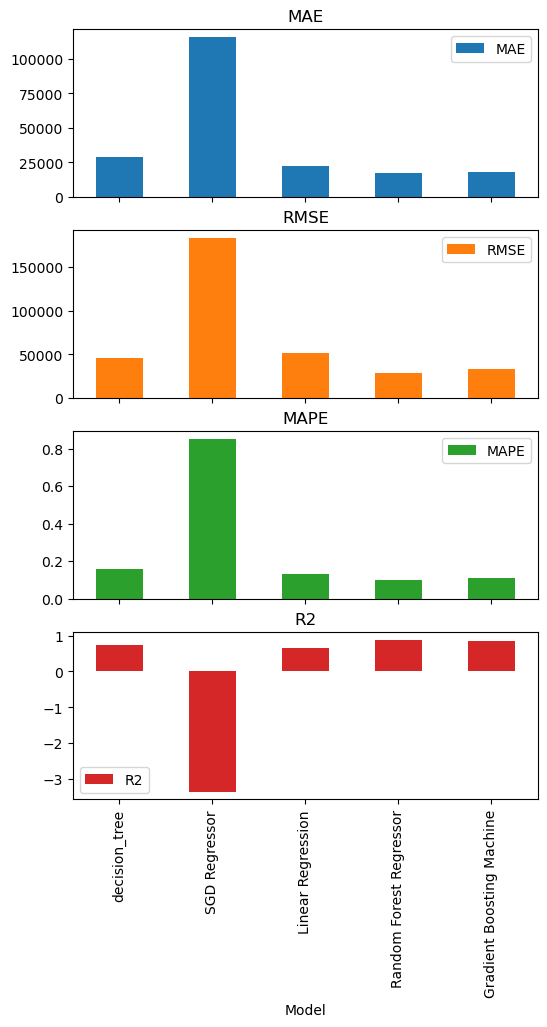

In [136]:
model_evaluation_metrics.plot.bar(subplots=True,
                             figsize=(6, 10),
                                 x='Model');